In [34]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from dfply import *
import tensorflow_recommenders as tfrs

%matplotlib inline

In [35]:
df = pd.read_csv("./data/ratings_Electronics.csv", names=['userId', 'productId','rating','timestamp'])

In [36]:
df.head()

,userId,productId,rating,timestamp
0,AKM1MP6P0OYPR,0132793040,5.0,1365811200
1,A2CX7LUOHB2NDG,0321732944,5.0,1341100800
2,A2NWSAGRHCP8N5,0439886341,1.0,1367193600
3,A2WNBOD3WNDNKT,0439886341,3.0,1374451200
4,A1GI0U4ZRJA8WN,0439886341,1.0,1334707200


In [37]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7824482 entries, 0 to 7824481
Data columns (total 4 columns):
 #   Column     Dtype  
---  ------     -----  
 0   userId     object 
 1   productId  object 
 2   rating     float64
 3   timestamp  int64  
dtypes: float64(1), int64(1), object(2)
memory usage: 238.8+ MB


In [38]:
print('The minimum rating is: %d' %(df['rating'].min()))
print('The maximum rating is: %d' %(df['rating'].max()))

The minimum rating is: 1
The maximum rating is: 5


/usr/local/lib/python3.9/site-packages/seaborn/categorical.py:3717: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
/usr/local/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


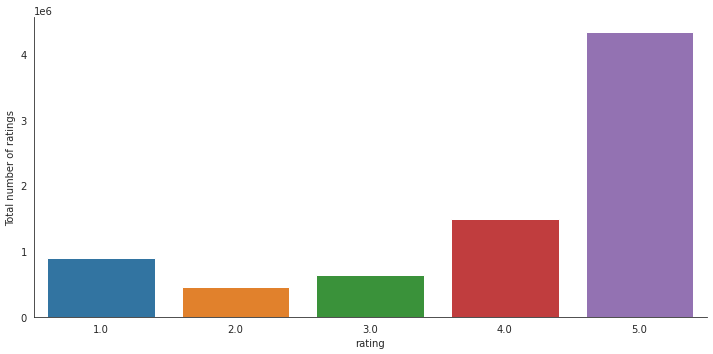

In [39]:
with sns.axes_style('white'):
    g = sns.factorplot("rating", data=df, aspect=2.0,kind='count')
    g.set_ylabels("Total number of ratings")

In [40]:
df=df.iloc[:500000,0:]
ds = tf.data.Dataset.from_tensor_slices(dict(df))

In [41]:
ds

<TensorSliceDataset shapes: {userId: (), productId: (), rating: (), timestamp: ()}, types: {userId: tf.string, productId: tf.string, rating: tf.float64, timestamp: tf.int64}>

In [90]:
ratings = ds.map(lambda x: {
    "productId": x["productId"],
    "userId": x["userId"],
    "timestamp": x["timestamp"],
    "rating": x["rating"]
})
products = ds.map(lambda x: x["productId"])
products = products.unique()

In [43]:
timestamps = np.concatenate(list(ratings.map(lambda x: x["timestamp"]).batch(100)))

max_timestamp = timestamps.max()
min_timestamp = timestamps.min()

timestamp_buckets = np.linspace(
    min_timestamp, max_timestamp, num=1000,
)

unique_product_ids = np.unique(np.concatenate(list(products.batch(1000))))
unique_user_ids = np.unique(np.concatenate(list(ratings.batch(1_000).map(
    lambda x: x["userId"]))))

In [44]:
class UserModel(tf.keras.Model):

  def __init__(self, use_timestamps):
    super().__init__()

    self._use_timestamps = use_timestamps

    self.user_embedding = tf.keras.Sequential([
        tf.keras.layers.StringLookup(
            vocabulary=unique_user_ids, mask_token=None),
        tf.keras.layers.Embedding(len(unique_user_ids) + 1, 32),
    ])

    if use_timestamps:
      self.timestamp_embedding = tf.keras.Sequential([
          tf.keras.layers.Discretization(timestamp_buckets.tolist()),
          tf.keras.layers.Embedding(len(timestamp_buckets) + 1, 32),
      ])
      self.normalized_timestamp = tf.keras.layers.Normalization(
          axis=None
      )

      self.normalized_timestamp.adapt(timestamps)

  def call(self, inputs):
    if not self._use_timestamps:
      return self.user_embedding(inputs["userId"])

    return tf.concat([
        self.user_embedding(inputs["userId"]),
        self.timestamp_embedding(inputs["timestamp"]),
        tf.reshape(self.normalized_timestamp(inputs["timestamp"]), (-1, 1)),
    ], axis=1)

In [45]:
class productModel(tf.keras.Model):

  def __init__(self):
    super().__init__()
    
    self.product_embedding = tf.keras.Sequential([
      tf.keras.layers.StringLookup(
          vocabulary=unique_product_ids, mask_token=None),
      tf.keras.layers.Embedding(len(unique_product_ids) + 1, 32)
    ])

  def call(self, product):
    return self.product_embedding(product)

In [49]:
class AmazonModel(tfrs.models.Model):

  def __init__(self, use_timestamps):
    super().__init__()
    self.query_model = tf.keras.Sequential([
      UserModel(use_timestamps),
      tf.keras.layers.Dense(32)
    ])

    self.candidate_model = tf.keras.Sequential([
      productModel(),
      tf.keras.layers.Dense(32)
    ])

    self.task= tfrs.tasks.Retrieval(
        metrics=tfrs.metrics.FactorizedTopK(
            candidates=products.batch(128).map(self.candidate_model),
        ),
    )

  def compute_loss(self, features, training=False):
    query_embeddings = self.query_model({
        "userId": features["userId"],
        "timestamp": features["timestamp"],
    })
    product_embeddings = self.candidate_model(features["productId"])

    return self.task(query_embeddings, product_embeddings)

In [50]:
tf.random.set_seed(42)
shuffled = ratings.shuffle(100_000, seed=42, reshuffle_each_iteration=False)

train = shuffled.take(100_000)
test = shuffled.skip(80_000).take(20_000)

cached_train = train.shuffle(100_000).batch(2048)
cached_test = test.batch(4096).cache()

In [51]:
model = AmazonModel(use_timestamps=True)
model.compile(optimizer=tf.keras.optimizers.Adagrad(0.1))

model.fit(cached_train, epochs=3,verbose=0)

train_accuracy = model.evaluate(
    cached_train, return_dict=True)["factorized_top_k/top_100_categorical_accuracy"]
test_accuracy = model.evaluate(
    cached_test, return_dict=True)["factorized_top_k/top_100_categorical_accuracy"]

print(f"Top-100 accuracy (train): {train_accuracy:.2f}.")
print(f"Top-100 accuracy (test): {test_accuracy:.2f}.")

Consider rewriting this model with the Functional API.
Consider rewriting this model with the Functional API.
Consider rewriting this model with the Functional API.
5/5 [==============================] - 174s 35s/step - factorized_top_k/top_1_categorical_accuracy: 0.3925 - factorized_top_k/top_5_categorical_accuracy: 0.4032 - factorized_top_k/top_10_categorical_accuracy: 0.4211 - factorized_top_k/top_50_categorical_accuracy: 0.5189 - factorized_top_k/top_100_categorical_accuracy: 0.5891 - loss: 11663.9710 - regularization_loss: 0.0000e+00 - total_loss: 11663.9710
Top-100 accuracy (train): 0.61.
Top-100 accuracy (test): 0.59.


In [64]:
user_model = tf.keras.Sequential([
  tf.keras.layers.StringLookup(
      vocabulary=unique_user_ids, mask_token=None),
  tf.keras.layers.Embedding(len(unique_user_ids) + 1, 32)
])

product_model = tf.keras.Sequential([
  tf.keras.layers.StringLookup(
      vocabulary=unique_product_ids, mask_token=None),
  tf.keras.layers.Embedding(len(unique_product_ids) + 1, 32)
])

metrics = tfrs.metrics.FactorizedTopK(
  candidates=products.batch(128).map(product_model)
)

task = tfrs.tasks.Retrieval(
  metrics=metrics
)

In [65]:
from typing import Dict, Text
class ProductRecModel(tfrs.Model):

  def __init__(self, user_model, product_model):
    super().__init__()
    self.product_model: tf.keras.Model = product_model
    self.user_model: tf.keras.Model = user_model
    self.task: tf.keras.layers.Layer = task

  def compute_loss(self, features: Dict[Text, tf.Tensor], training=False) -> tf.Tensor:
    user_embeddings = self.user_model(features["userId"])
    positive_product_embeddings = self.product_model(features["productId"])

    # The task computes the loss and the metrics.
    return self.task(user_embeddings, positive_product_embeddings)

In [67]:
model = ProductRecModel(user_model, product_model)
model.compile(optimizer=tf.keras.optimizers.Adagrad(learning_rate=0.1))

In [68]:
model.fit(cached_train, epochs=3,verbose=0)

In [69]:
model.evaluate(cached_test, return_dict=True)

5/5 [==============================] - 147s 30s/step - factorized_top_k/top_1_categorical_accuracy: 0.2871 - factorized_top_k/top_5_categorical_accuracy: 0.2871 - factorized_top_k/top_10_categorical_accuracy: 0.2871 - factorized_top_k/top_50_categorical_accuracy: 0.2873 - factorized_top_k/top_100_categorical_accuracy: 0.2967 - loss: 23998.0801 - regularization_loss: 0.0000e+00 - total_loss: 23998.0801


{'factorized_top_k/top_1_categorical_accuracy': 0.2870999872684479,
 'factorized_top_k/top_5_categorical_accuracy': 0.2870999872684479,
 'factorized_top_k/top_10_categorical_accuracy': 0.2870999872684479,
 'factorized_top_k/top_50_categorical_accuracy': 0.28734999895095825,
 'factorized_top_k/top_100_categorical_accuracy': 0.29670000076293945,
 'loss': 22173.81640625,
 'regularization_loss': 0,
 'total_loss': 22173.81640625}

In [92]:
index = tfrs.layers.factorized_top_k.BruteForce(model.user_model)

index.index_from_dataset(
  tf.data.Dataset.zip((products.batch(100), products.batch(100).map(model.product_model)))
)

# Get recommendations.
_, product = index(tf.constant(["AGHZXQL9F94T9"]))
print(f"Recommendations for user AGHZXQL9F94T9: {product[0, :5]}")

Recommendations for user AGHZXQL9F94T9: [b'B0000645C9' b'B000066E6Y' b'B00000JDF5' b'B00005OQMO' b'0972683275']


In [76]:
df >> mask(X.userId == "A2WNBOD3WNDNKT")

,userId,productId,rating,timestamp
3,A2WNBOD3WNDNKT,0439886341,3.0,1374451200


In [80]:
len(df >> mask(X.productId == "B0000645C9"))

120